# I Perkenalan

=================================================

Nama  : Gieorgie Kharismatik Kosasih


=================================================

## Problem

Membuat model machine learning classification untuk dapat memprediksi default_payment customers dengan menggunakan data yang ada

## Latar Belakang

Sebuah bank ingin mengidentifikasi customers kartu kredit yang mengalami kredit macet melalui data riwayat pembayaran kartu kredit yang dimiliki oleh bank. Data terdapat keterangan nominal pembayaran yang pernah dilakukan , tagihan kartu kredit , data customers, riwayat pembayaran, serta keterangan keterlambatan pembayaran. Bank ingin lebih baik lagi untuk memprediksi customers yang berpotensi gagal bayar dan tidak gagal bayar melalui model machine learning.

## Objective

Mampu mengimplementasikan algoritma machine learning classification yaitu Logistict Regression, SVM, dan KNN mulaidari pemahaman konsep, persiapan data serta hyperparameter yang digunakan.

# II Query SQL

    from google.colab import auth
    from google.cloud import bigquery
    auth.authenticate_user()
    print('Authenticated')

    project_id = "kisi-kisi-lc"
    client = bigquery.Client(project=project_id)

    df = client.query('''
    SELECT 
      limit_balance,
      CAST(sex AS INT64) AS sex, -- Mengkonversi sex dari STRING ke INT64
      CAST(education_level AS INT64) AS education_level, -- Mengkonversi education_level dari STRING ke INT64
      CAST(marital_status AS INT64) AS marital_status, -- Mengkonversi marital_status dari STRING ke INT64
      age,
      pay_0,
      pay_2,
      pay_3,
      pay_4,
      CAST(pay_5 AS FLOAT64) AS pay_5, -- Mengkonversi pay_5 dari STRING ke FLOAT64
      CAST(pay_6 AS FLOAT64) AS pay_6, -- Mengkonversi pay_6 dari STRING ke FLOAT64
      bill_amt_1,
      bill_amt_2,
      bill_amt_3,
      bill_amt_4,
      bill_amt_5,
      bill_amt_6,
      pay_amt_1,
      pay_amt_2,
      pay_amt_3,
      pay_amt_4,
      pay_amt_5,
      pay_amt_6,
      CAST(default_payment_next_month AS INT64) AS default_payment_next_month -- Mengkonversi default_payment_next_month dari STRING ke INT64
    FROM 
      `bigquery-public-data.ml_datasets.credit_card_default`
    LIMIT 61938''').to_dataframe()

- Data yang sudah di ambil dalam bigquery disimpan kedalam dataframe kemudian disimpan kembali ke format csv agar dapat dikerjakan dalam vscode
- Walau pada query data diambil 61938 baris tapi data tersebut pada bigquery hanya sebanyak 2965 baris saja


# III Import Libraries

In [50]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Statistic
from scipy.stats import kendalltau
from scipy.stats import chi2_contingency

# Data Spliting
from sklearn.model_selection import train_test_split

# Model
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Pipeline
from sklearn.pipeline import Pipeline

# Transformer
from sklearn.compose import ColumnTransformer

# Scalling
from sklearn.preprocessing import RobustScaler

# Metric Evaluation
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score

# Capping Data
from feature_engine.outliers import Winsorizer


# Save Model
import pickle
import json


# IV Data Loading

In [51]:
# Load Data
pd.set_option('display.max_columns', None)
df = pd.read_csv('P1G5_Set_1_gieorgie.csv')
df.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,-1.0,54053.0,65235.0,64747.0,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,0.0,192461.0,195970.0,122214.0,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,0.0,133598.0,167378.0,171106.0,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,0.0,160879.0,161797.0,165107.0,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


In [52]:
# Menampilkan 10 baris terbawah
df.tail(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,1968.0,459.0,2500.0,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,-2.0,12878.0,7702.0,2377.0,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-100.0,100.0,0.0,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,-1.0,5280.0,5000.0,5000.0,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,96.0,780.0,0.0,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,4280.0,2800.0,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,752.0,300.0,5880.0,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1473.0,390.0,390.0,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-70.0,9540.0,390.0,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


In [53]:
# Menampilkan jumlah baris dan kolom
print(f'Jumlah baris : {df.shape[0]}')
print(f'Jumlah kolom : {df.shape[1]}')

Jumlah baris : 2965
Jumlah kolom : 24


In [54]:
# Menampilkan info data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

## Keterangan Kolom

limit_balance: Batas kredit yang diberikan kepada pemegang kartu (dalam dolar Taiwan Baru, NT dollar).

sex: Jenis kelamin pemegang kartu (1 = laki-laki, 2 = perempuan).

education_level: Tingkat pendidikan pemegang kartu:

1: Sekolah Menengah Atas
2: Sarjana
3: Pascasarjana
4: Lainnya
(0, 5, 6 juga mungkin ada, di mana 0 = tidak diketahui, 5 = sekolah dasar, 6 = lainnya)
marital_status: Status pernikahan pemegang kartu:

1: Menikah
2: Lajang
3: Lainnya
(0 juga mungkin ada, di mana 0 = tidak diketahui)
age: Usia pemegang kartu (dalam tahun).

pay_0: Status pembayaran bulan sebelumnya (bulan ke-0). Nilai numerik menunjukkan keterlambatan pembayaran (misalnya, 0 = tidak ada keterlambatan, 1 = terlambat 1 bulan, 2 = terlambat 2 bulan, dan seterusnya, -1 = pembayaran tepat waktu).

pay_2: Status pembayaran dua bulan sebelumnya (bulan ke-2). Nilai numerik menunjukkan keterlambatan pembayaran.

pay_3: Status pembayaran tiga bulan sebelumnya (bulan ke-3). Nilai numerik menunjukkan keterlambatan pembayaran.

pay_4: Status pembayaran empat bulan sebelumnya (bulan ke-4). Nilai numerik menunjukkan keterlambatan pembayaran.

pay_5: Status pembayaran lima bulan sebelumnya (bulan ke-5). Nilai numerik menunjukkan keterlambatan pembayaran.

pay_6: Status pembayaran enam bulan sebelumnya (bulan ke-6). Nilai numerik menunjukkan keterlambatan pembayaran.

bill_amt_1: Jumlah tagihan (NT dollar) pada akhir bulan ke-1.

bill_amt_2: Jumlah tagihan (NT dollar) pada akhir bulan ke-2.

bill_amt_3: Jumlah tagihan (NT dollar) pada akhir bulan ke-3.

bill_amt_4: Jumlah tagihan (NT dollar) pada akhir bulan ke-4.

bill_amt_5: Jumlah tagihan (NT dollar) pada akhir bulan ke-5.

bill_amt_6: Jumlah tagihan (NT dollar) pada akhir bulan ke-6.

pay_amt_1: Jumlah pembayaran yang dilakukan (NT dollar) pada bulan ke-1.

pay_amt_2: Jumlah pembayaran yang dilakukan (NT dollar) pada bulan ke-2.

pay_amt_3: Jumlah pembayaran yang dilakukan (NT dollar) pada bulan ke-3.

pay_amt_4: Jumlah pembayaran yang dilakukan (NT dollar) pada bulan ke-4.

pay_amt_5: Jumlah pembayaran yang dilakukan (NT dollar) pada bulan ke-5.

pay_amt_6: Jumlah pembayaran yang dilakukan (NT dollar) pada bulan ke-6.

default_payment_next_month: Status apakah pemegang kartu gagal membayar pada bulan berikutnya (1 = gagal bayar, 0 = tidak gagal bayar).

In [55]:
# menampilkan unique value beserta valuenya
pd.set_option('display.max_colwidth', 1)
listItem = []
for i,col in enumerate(df.columns) :
    listItem.append( [col, df[col].nunique(), df[col].unique()])
    

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Value'],data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Value
0,limit_balance,59,"[80000.0, 200000.0, 20000.0, 260000.0, 150000.0, 300000.0, 130000.0, 500000.0, 230000.0, 460000.0, 780000.0, 170000.0, 320000.0, 290000.0, 240000.0, 340000.0, 360000.0, 380000.0, 180000.0, 100000.0, 90000.0, 50000.0, 160000.0, 70000.0, 280000.0, 220000.0, 30000.0, 120000.0, 10000.0, 470000.0, 310000.0, 140000.0, 60000.0, 110000.0, 430000.0, 210000.0, 490000.0, 330000.0, 250000.0, 400000.0, 370000.0, 440000.0, 700000.0, 530000.0, 390000.0, 410000.0, 270000.0, 560000.0, 40000.0, 680000.0, 480000.0, 190000.0, 350000.0, 420000.0, 510000.0, 800000.0, 450000.0, 750000.0, 620000.0]"
1,sex,2,"[1, 2]"
2,education_level,7,"[6, 4, 1, 2, 3, 5, 0]"
3,marital_status,4,"[1, 2, 3, 0]"
4,age,49,"[54.0, 49.0, 22.0, 33.0, 32.0, 45.0, 58.0, 39.0, 48.0, 34.0, 47.0, 46.0, 30.0, 35.0, 55.0, 42.0, 56.0, 31.0, 53.0, 40.0, 36.0, 51.0, 37.0, 44.0, 24.0, 38.0, 26.0, 25.0, 23.0, 27.0, 28.0, 29.0, 41.0, 63.0, 50.0, 43.0, 66.0, 61.0, 52.0, 62.0, 69.0, 21.0, 65.0, 57.0, 64.0, 67.0, 60.0, 59.0, 68.0]"
5,pay_0,11,"[0.0, 2.0, 1.0, -1.0, -2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]"
6,pay_2,10,"[0.0, -1.0, 2.0, 3.0, -2.0, 4.0, 1.0, 5.0, 6.0, 7.0]"
7,pay_3,9,"[0.0, 2.0, -2.0, 3.0, -1.0, 4.0, 5.0, 6.0, 7.0]"
8,pay_4,10,"[0.0, -1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, -2.0]"
9,pay_5,9,"[0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, -1.0, -2.0]"


Berdasarkan Tabel unique value di atas dapat dikatakan kolom kategorikal pada dataset adalah kolom 'sex', 'education_level', 'marital_status', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6','default_payment_next_month' dan kolom numerical adalah 'limit_balance','bill_amt_1','bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6','pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5','pay_amt_6'.

In [56]:
# Menghitung missing value pada data
data_null = df.isna().sum().reset_index().rename(columns={'index':'variable',0:'null count'})
# Menghitung presentase missing value pada data
data_null['null percentage'] = data_null['null count'].apply(lambda x: (x/(df.shape[0]))*100)
data_null

,variable,null count,null percentage
0,limit_balance,0,0.0
1,sex,0,0.0
2,education_level,0,0.0
3,marital_status,0,0.0
4,age,0,0.0
5,pay_0,0,0.0
6,pay_2,0,0.0
7,pay_3,0,0.0
8,pay_4,0,0.0
9,pay_5,0,0.0


In [57]:
# Check Duplicates
print('Jumlah data duplikat:', df.duplicated().sum())

Jumlah data duplikat: 1


Dikarenakan tidak ada label yang membedakan setiap pembayaran customers maka data tidak dapat disimpulkan jika duplikasi tersebut valid atau customers secara kebetulan memiliki keterangan yang sama. Tetapi melihat duplikasi yang ditemukan hanya satu baris maka duplikasi tersebut akan dilakukan drop.

In [58]:
# Menghapus duplikasi data
df.drop_duplicates(inplace=True)

# V Exploratory Data Analysis (EDA)

Pada tahapan ini akan dilakukan explorasi pada dataset dimana explorasi akan berfokus pada seleksi kolom yang akan menjadi calon feature untuk mendukung proses feature selection mengingat kolom dataset memiliki banyak kolom. hal yang dilakukan meliputi melihat distribusi data, mencari variable independent dan dependent.

## Customers Default Next Month

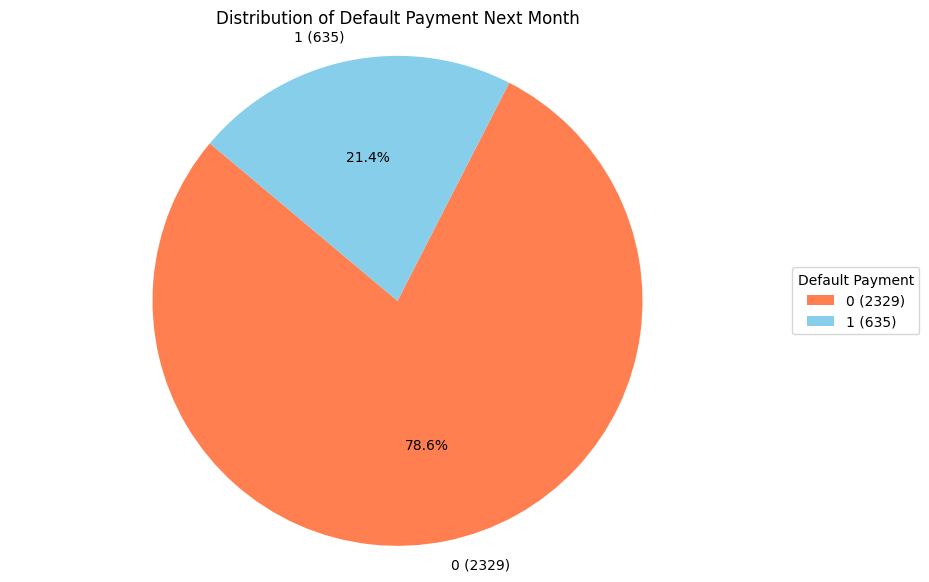

In [59]:
# Menghitung jumlah tiap kategori
default_counts = df['default_payment_next_month'].value_counts()

# Membuat label dengan jumlah nilai
labels = [f'{label} ({count})' for label, count in zip(default_counts.index, default_counts)]

# Membuat pie chart
plt.figure(figsize=(10, 7))
plt.pie(default_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['coral', 'skyblue'])
plt.title('Distribution of Default Payment Next Month')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Menambahkan legenda
plt.legend(labels, title='Default Payment', loc='center left', bbox_to_anchor=(1, 0.5))

# Menampilkan plot
plt.show()

Pada grafik menunjukan bahwa customers yang membayar tepat waktu lebih banyak dari pada yang tidak tepat waktu, ini juga menunjukkan bahwa data termasuk imbalance data dimana salah satu sampel lebih banyak dari yang lain.

## Customers Previous Month's Payment

In [60]:
# cross tabulasi
pd.crosstab(index=df['default_payment_next_month'], columns=df['pay_0'])


pay_0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
default_payment_next_month,,,,,,,,,,,
0,213,474,1319,244,69,3,3,2,1,0,1
1,34,66,197,111,193,26,4,0,0,2,2


C:\Users\User\AppData\Local\Temp\ipykernel_8128\2317404884.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())


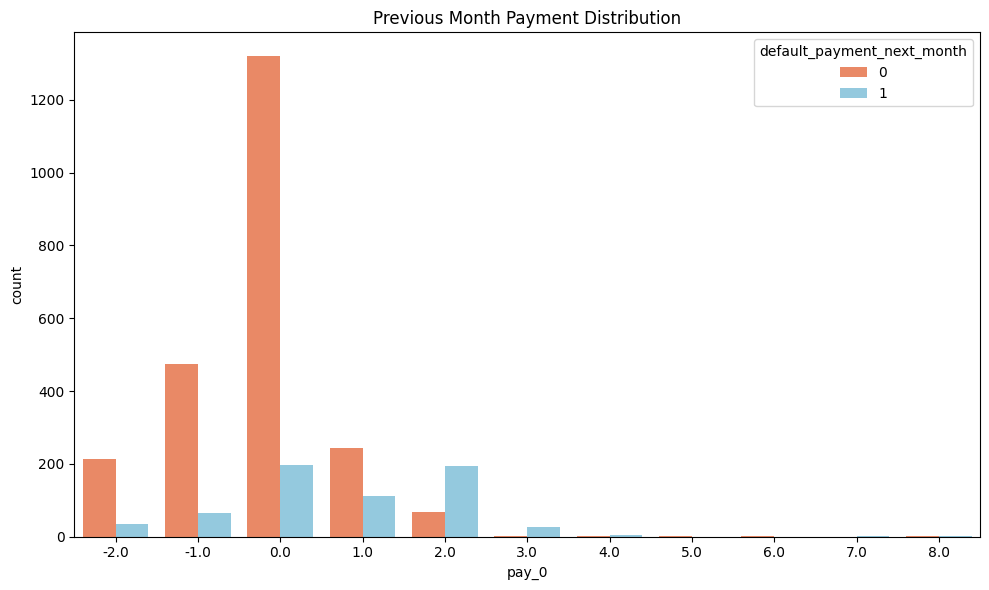

In [61]:
# Membuat Countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='pay_0', hue='default_payment_next_month', palette=['coral', 'skyblue'])
ax.set_title('Previous Month Payment Distribution')
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.show()

Berdasarkan pengamatan riwayat pembayaran pada bulan sebelumnya seluruh customers dapat berpotensi mengalami gagal bayar akan tetapi customers yang melakukan keterlambatan pembayaran sebelumnya berpotensi lebih besar mengalami gagal bayar pada bulan selanjutnya terlebih ketika customers mengalami keterlambatan bayar lebih dari 2 bulan maka berdasarkan data ini dapat dipastikan kemungkinan customers tersebut akan gagal bayar pada bulan selanjutnya.

## Customers Marital Status

In [62]:
#cross tabulasi
pd.crosstab(index=df['default_payment_next_month'], columns=df['marital_status'])

marital_status,0,1,2,3
default_payment_next_month,,,,
0,4,1029,1267,29
1,0,302,327,6


C:\Users\User\AppData\Local\Temp\ipykernel_8128\182763933.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())


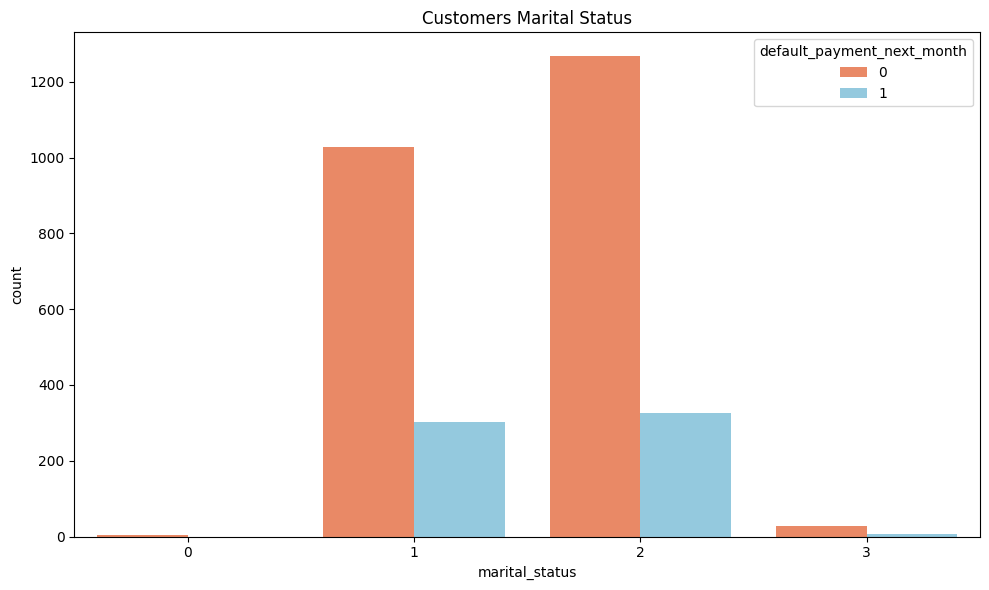

In [63]:
# Membuat Countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='marital_status', hue='default_payment_next_month', palette=['coral', 'skyblue'])
ax.set_title('Customers Marital Status')
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.show()

Analisis data berdasarkan status pernikahan menunjukkan bahwa pelanggan yang belum menikah (status 1) dan menikah (status 2) memiliki jumlah gagal bayar tertinggi masing-masing sebesar 302 (22,7%) dan 327 (20,5%), sementara yang berstatus lainnya memiliki tingkat gagal bayar yang sangat rendah.

## Customers Education Level

In [64]:
#cross tabulasi
pd.crosstab(index=df['default_payment_next_month'], columns=df['education_level'])

education_level,0,1,2,3,4,5,6
default_payment_next_month,,,,,,,
0,2,861,1058,370,13,23,2
1,0,177,342,113,0,1,2


C:\Users\User\AppData\Local\Temp\ipykernel_8128\3425826409.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())


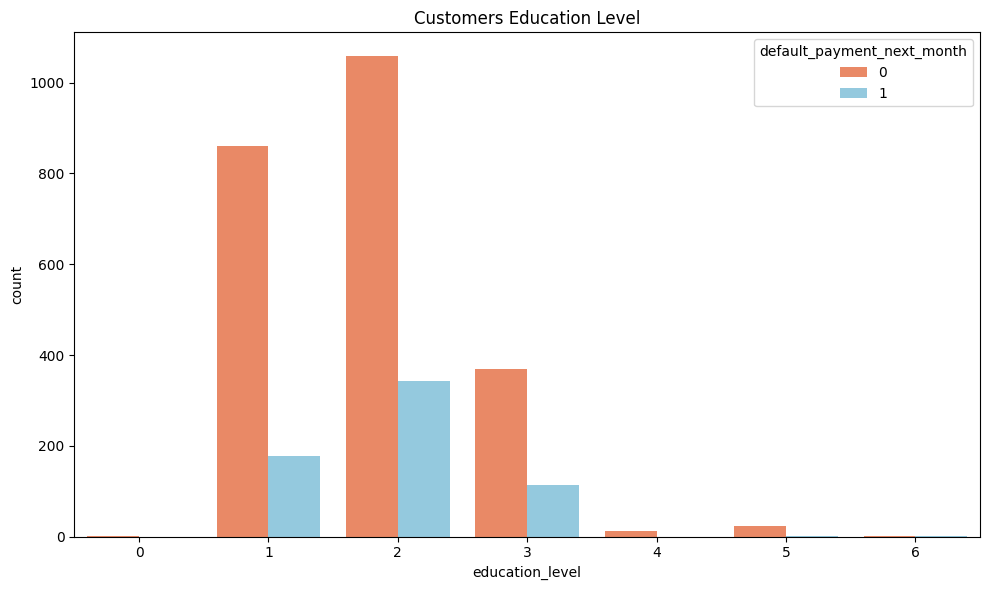

In [65]:
# Membuat Countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='education_level', hue='default_payment_next_month', palette=['coral', 'skyblue'])
ax.set_title('Customers Education Level')
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.show()

Analisis data berdasarkan tingkat pendidikan menunjukkan bahwa pelanggan dengan tingkat pendidikan 1 (sekolah menengah) dan 2 (sarjana) memiliki jumlah gagal bayar tertinggi masing-masing sebesar 177 (16,9%) dan 342 (24,4%), sedangkan pelanggan dengan pendidikan 3 (magister) memiliki 113 gagal bayar (23,4%). Pelanggan dengan pendidikan yang lebih rendah (0) atau lebih tinggi (4, 5, 6) memiliki tingkat gagal bayar yang sangat rendah atau tidak ada.

## Customers Gender

In [66]:
# cross tabulasi
pd.crosstab(index=df['default_payment_next_month'], columns=df['sex'])

sex,1,2
default_payment_next_month,,
0,901,1428
1,262,373


C:\Users\User\AppData\Local\Temp\ipykernel_8128\34341655.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())


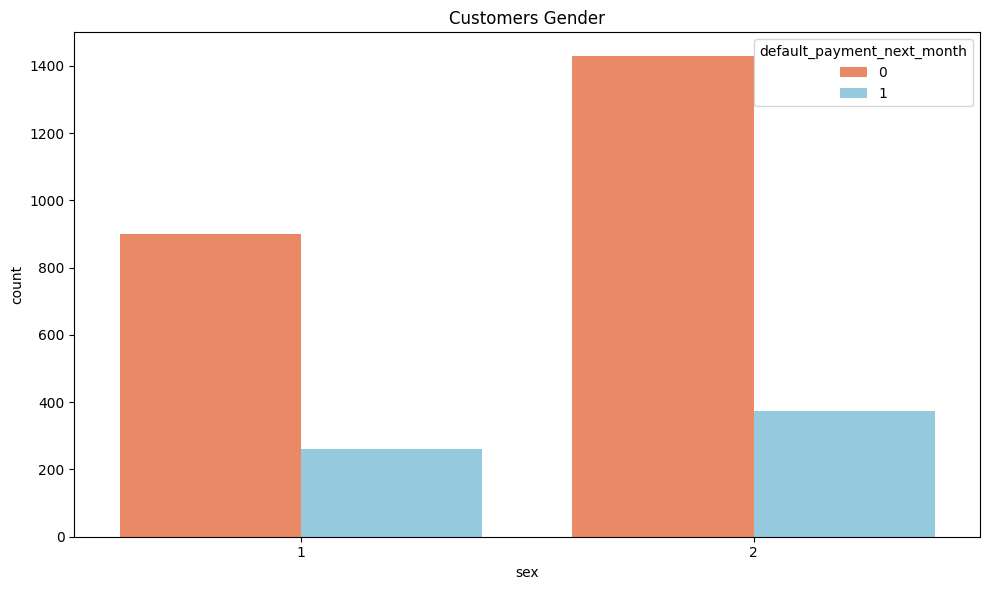

In [67]:
# Membuat Countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='sex', hue='default_payment_next_month', palette=['coral', 'skyblue'])
ax.set_title('Customers Gender')
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.show()

Analisis data menunjukkan bahwa dari 1163 laki-laki, 22,5% (262) gagal bayar, sedangkan dari 1801 perempuan, 20,7% (373) gagal bayar, menandakan laki-laki memiliki sedikit risiko lebih tinggi untuk gagal bayar dibandingkan perempuan. Meskipun jumlah perempuan lebih banyak, mereka cenderung lebih sedikit gagal bayar.

## Korelasi antar target dan kolom lain

In [68]:
# memisahakn kolom dengan kategori masing masing
cat_columns = ['sex', 'education_level', 'marital_status','pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
num_columns = ['limit_balance','age','bill_amt_1','bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
           'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5','pay_amt_6']

In [69]:
# membagi kolom categorical dan numerical
df_num = df[num_columns]
df_cat = df[cat_columns]

## Korelasi target dengan kolom categorical

Karena target merupakan kolom kategorikal maka korelasi antar kolom kategorikal dan kolom target menggunakan chi2_contigency 

HO : tidak ada hubungan antara kolom katergorikal dan kolom target

H1 : terdapat hungungan antara kolom kategorikal dan kolom target

In [70]:
# Menghitung chi-square p-value untuk setiap kolom categorical
chi2_p_values = {}

for col in cat_columns:
    contingency_table = pd.crosstab(df[col], df['default_payment_next_month'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    chi2_p_values[col] = p

# Mengubah hasil menjadi DataFrame
chi2_p_values_df = pd.DataFrame.from_dict(chi2_p_values, orient='index', columns=['p_value'])


In [71]:
# menampilkan hasil korelasi chi square
chi2_p_values_df

,p_value
sex,2.578208e-01
education_level,2.911281e-05
marital_status,3.179554e-01
pay_0,1.556692e-131
pay_2,5.829612e-79
pay_3,2.092859e-68
pay_4,5.168480e-61
pay_5,1.752247e-60
pay_6,1.164491e-51


Berdasarkan hasil pengujian chi-square terhadap kolom kategorical terhadap target didapat korelasi yang tidak signifikan ada pada kolom sex dan marital_status.

## Korelasi target dengan kolom numerical

In [72]:
# Inisialisasi list untuk menyimpan hasil
p_values = []
interpretation = []
cols = []
corr = []
selected_num_cols = []

# Loop melalui setiap kolom numerik dalam dataframe
for col in df_num.columns:
    # Hitung koefisien korelasi Spearman dan nilai p
    corr_coef, p_value = kendalltau(df_num[col], df['default_payment_next_month'])

    # Simpan hasil perhitungan ke dalam list yang sesuai
    p_values.append(p_value)
    cols.append(col)
    corr.append(corr_coef)

    # Tentukan apakah korelasi signifikan berdasarkan nilai p-value
    if p_value < 0.05:
        interpretation.append('Significant')
        selected_num_cols.append(col)  # Tambahkan kolom ke daftar kolom yang dipilih jika signifikan
    else:
        interpretation.append('Not Significant')

# Buat DataFrame untuk meringkas hasil
result_df = pd.DataFrame({
    'Column Name': cols,
    'Correlation Coefficient': corr,
    'P-value': p_values,
    'Correlation': interpretation
})

# Tampilkan DataFrame hasil
result_df

,Column Name,Correlation Coefficient,P-value,Correlation
0,limit_balance,-0.144756,2.945643e-21,Significant
1,age,0.008212,5.903515e-01,Not Significant
2,bill_amt_1,-0.003175,8.327578e-01,Not Significant
3,bill_amt_2,0.005342,7.225697e-01,Not Significant
4,bill_amt_3,0.008624,5.669441e-01,Not Significant
5,bill_amt_4,0.014310,3.424885e-01,Not Significant
6,bill_amt_5,0.018549,2.191143e-01,Not Significant
7,bill_amt_6,0.023517,1.195408e-01,Not Significant
8,pay_amt_1,-0.119591,3.938414e-15,Significant
9,pay_amt_2,-0.119574,4.197685e-15,Significant


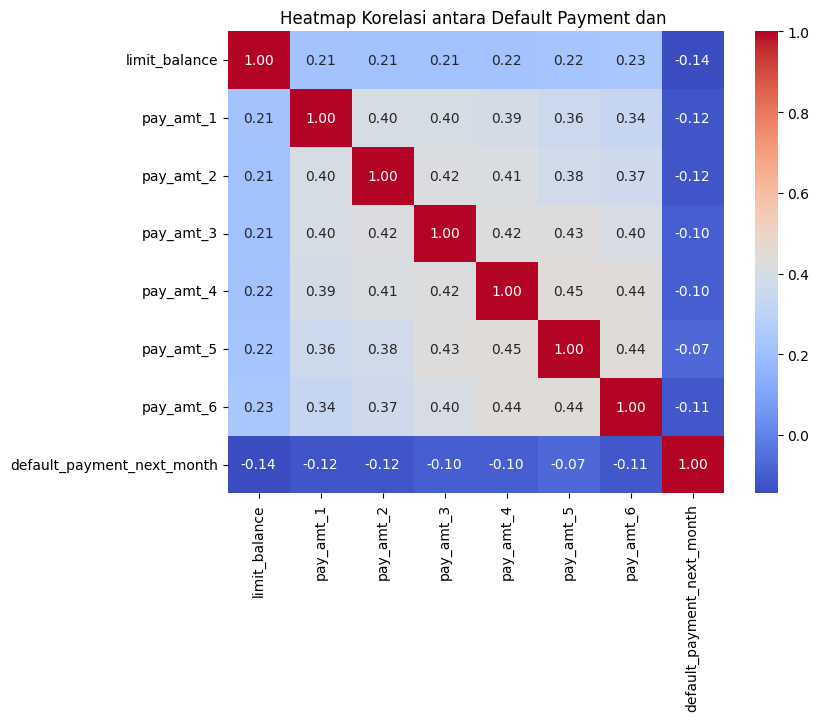

In [73]:
# Hitung matriks korelasi menggunakan metode Spearman
corr_matrix = df[['limit_balance','pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6', 'default_payment_next_month']].corr(method='kendall')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi antara Default Payment dan ')
plt.show()

- Terdapat korelasi positif yang cukup kuat antara jumlah pembayaran pada bulan-bulan yang berurutan. Misalnya, pay_amt_1 memiliki korelasi positif yang cukup tinggi dengan pay_amt_2 (0.40) dan seterusnya hingga pay_amt_6.
- limit_balance memiliki korelasi positif yang lemah dengan setiap jumlah pembayaran (pay_amt_1 hingga pay_amt_6), dengan nilai korelasi berkisar antara 0.21 hingga 0.23.
- default_payment_next_month memiliki korelasi negatif dengan limit_balance (-0.14) dan semua jumlah pembayaran (pay_amt_1 hingga pay_amt_6), dengan nilai korelasi berkisar antara -0.07 hingga -0.14.

Atas dasar hasil pengujian korelasi antar kolom ini maka kolom yang akan dipilih menjadi fitur adalah kolom yang berkorelasi tinggi dengan target

## Membuat data inference

Data inference merupakan unseen data atau data yang tidak termasuk dalam test atau train. Sebelum melakukan spliting akan diambil beberapa data untuk dijadikan sebagai bahan uji model pada tahap model inference

In [74]:
# membuat data inferece
data_inf = df.sample(2, random_state=10)
data_inf

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2423,360000.0,2,2,2,53.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,10733.0,15206.0,15000.0,9744.0,11114.0,8123.0,15206.0,15032.0,9769.0,11114.0,8123.0,8736.0,0
2555,260000.0,1,1,2,30.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,2322.0,1233.0,3302.0,6592.0,5008.0,3386.0,1233.0,3302.0,6592.0,5008.0,3386.0,2547.0,0


In [75]:
# Menghapus inference set dari dataset awal

df = df.drop(data_inf.index)
df

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,4280.0,2800.0,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,752.0,300.0,5880.0,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1473.0,390.0,390.0,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0


In [76]:
# membuat data inference
data_inf.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

data_inf

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,360000.0,2,2,2,53.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,10733.0,15206.0,15000.0,9744.0,11114.0,8123.0,15206.0,15032.0,9769.0,11114.0,8123.0,8736.0,0
1,260000.0,1,1,2,30.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,2322.0,1233.0,3302.0,6592.0,5008.0,3386.0,1233.0,3302.0,6592.0,5008.0,3386.0,2547.0,0


# VI Feature Engineering

## Feature Selection

Berdasarkan hasil EDA maka kolom yang digunakan untuk menjadi fitur adalah kolom yang memiliki korelasi yang signifikan terhadap target.

In [77]:
# Pemilihan fitur
df_feature = df[['default_payment_next_month','limit_balance','education_level',
                 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
                 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
                 'pay_amt_6']]
df_feature.head()

,default_payment_next_month,limit_balance,education_level,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,1,80000.0,6,0.0,0.0,0.0,0.0,0.0,0.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0
1,0,200000.0,4,0.0,0.0,0.0,0.0,0.0,0.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0
2,1,20000.0,6,0.0,0.0,0.0,0.0,0.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0
3,0,260000.0,4,0.0,0.0,0.0,0.0,0.0,0.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0
4,0,150000.0,4,0.0,0.0,0.0,-1.0,0.0,0.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0


## Data Split Train Test

In [78]:
# Define features and target variable
X = df_feature.drop('default_payment_next_month', axis=1)
y = df_feature['default_payment_next_month'] #yang di prediksi

# Split df into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
print('Train Size: ', X_train.shape)
print('Test Size: ', X_test.shape)

Train Size:  (2369, 14)
Test Size:  (593, 14)


## Handling Missing Value

In [79]:
# cek missing value
X_train.isnull().sum()

limit_balance      0
education_level    0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [80]:
# cek missing value
X_test.isnull().sum()

limit_balance      0
education_level    0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [81]:
# cek missing value
y_train.isnull().sum()

0

In [82]:
# cek missing value
y_test.isnull().sum()

0

Tidak terdapat missing value pada data

## Outlier Handling

Pada tahapan ini outlier akan di identifikasi kemudian dilakukan penanganan menggunakan metode capping sesuai dengan distribusi pada fitur.

In [83]:
# Selecting numerical and categorical columns
cat_columns = ['education_level','pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
num_columns = ['limit_balance','pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 
               'pay_amt_5','pay_amt_6']

print('Categorical Columns: ', cat_columns)
print('Numerical Columns: ', num_columns)

Categorical Columns:  ['education_level', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
Numerical Columns:  ['limit_balance', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']


In [84]:
# Making data and columns for normal distribution
data_normal = []
column_normal = []

# Making data and columns for skewed distribution
data_skewed = []
column_skewed = []

# For loop in every numerical column to filter the data distribution into either normally distributed or skewed columns
for num in num_columns:
    skewness = X_train[num].skew()

    # If the data is normally distributed
    if skewness <= 0.5 and skewness >= -0.5:
        column_normal.append(num)
        data_normal.append([num, skewness])

    # If the data has low negative skewness
    elif skewness < -1:
        column_skewed.append(num)
        data_skewed.append([num, skewness, 'high'])

    # If the data has low positive skewness
    elif skewness > 1:
        column_skewed.append(num)
        data_skewed.append([num, skewness, 'high'])

    # If the data has moderate negative skewness
    elif skewness <= -0.5 and skewness > -1:
        column_skewed.append(num)
        data_skewed.append([num, skewness, 'low'])

    # If the data has moderate positive skewness
    elif skewness >= 0.5 and skewness < 1:
        column_skewed.append(num)
        data_skewed.append([num, skewness, 'low'])

In [85]:
# Showing normally distributed columns
pd.DataFrame(data=data_normal, columns=['normal_distribution', 'skewness'])

,normal_distribution,skewness


In [86]:
# Showing skewed columns
pd.DataFrame(data=data_skewed, columns=['skewed_distribution', 'skewness', 'rate'])

,skewed_distribution,skewness,rate
0,limit_balance,1.018271,high
1,pay_amt_1,11.369071,high
2,pay_amt_2,27.827237,high
3,pay_amt_3,8.221144,high
4,pay_amt_4,9.286806,high
5,pay_amt_5,9.967901,high
6,pay_amt_6,10.070584,high


In [87]:
# Capping Method for Skewed Distribution
winsorizer_skewed = Winsorizer(capping_method='iqr',
                            tail='both',
                            fold=3,
                            variables=num_columns)

# Fit & Transforming X_train
X_train_capped = winsorizer_skewed.fit_transform(X_train)

# Transforming X_test
X_test_capped = winsorizer_skewed.transform(X_test)

In [88]:
# Plot Distribution Comparison
def outlier_handling_plot_comparison(df_before, df_after, variable):

    # Figure Size, and Super Title based on variable
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{variable} - Distribution Before and After Outlier Handling')

    # Plot Histogram Before
    sns.histplot(df_before[variable], bins=30, ax=axes[0, 0], color='coral')
    axes[0, 0].set_title('Histogram Before')

    # Plot Boxplot Before
    sns.boxplot(y=df_before[variable], ax=axes[1, 0])
    axes[1, 0].set_title('Boxplot Before')

    # Plot Histogram After
    sns.histplot(df_after[variable], bins=30, ax=axes[0, 1], color='coral')
    axes[0, 1].set_title('Histogram After')

    # Plot Boxplot After
    sns.boxplot(y=df_after[variable], ax=axes[1, 1])
    axes[1, 1].set_title('Boxplot After')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

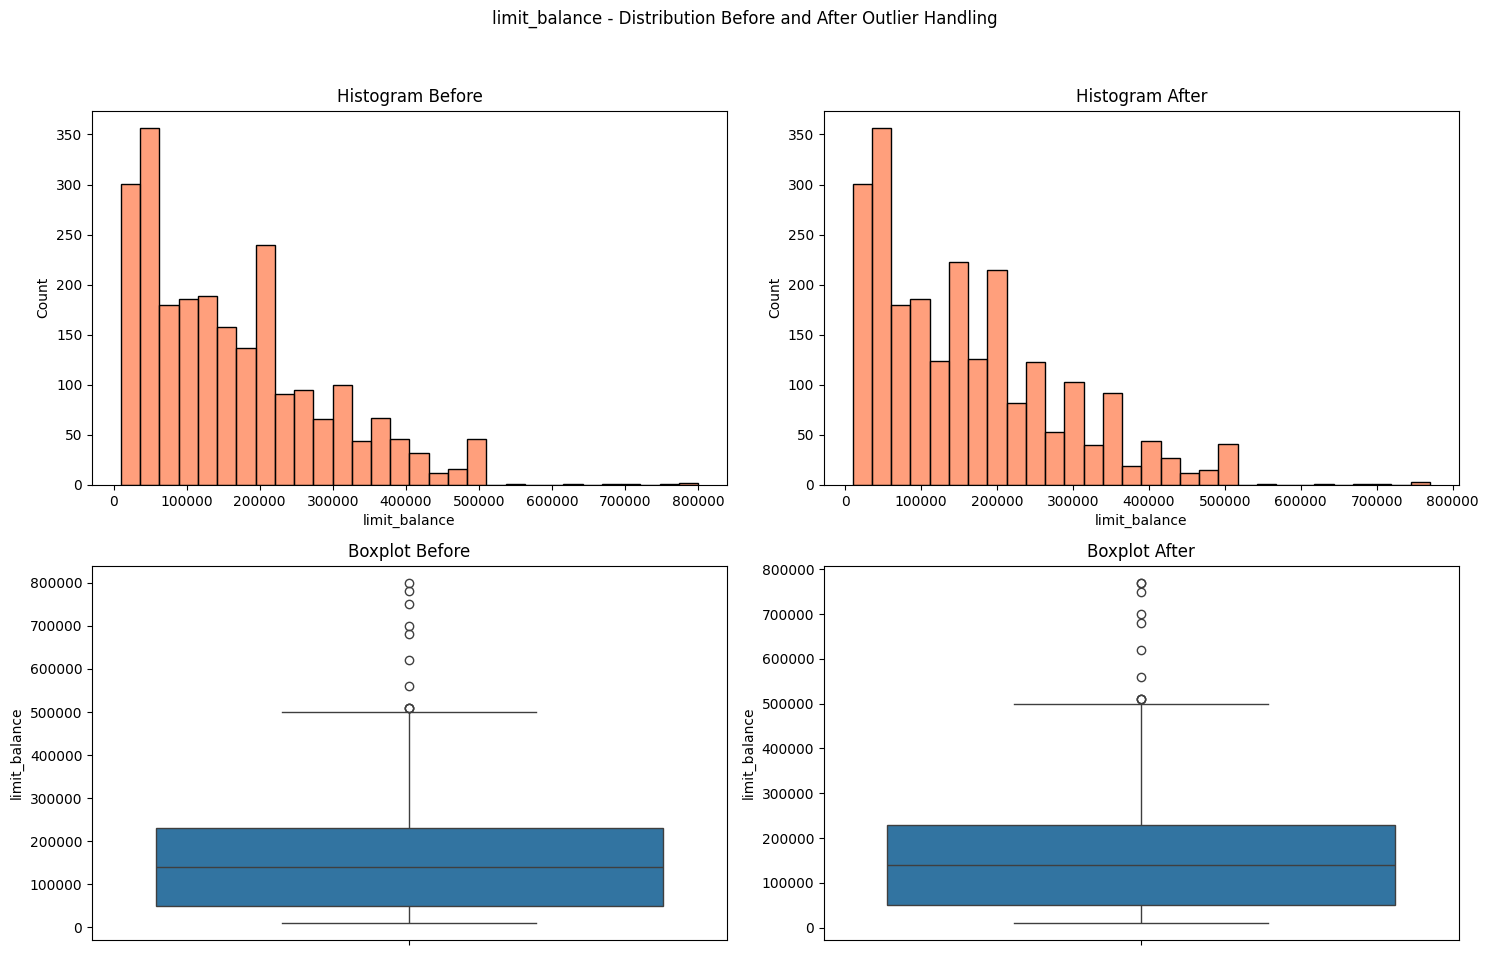

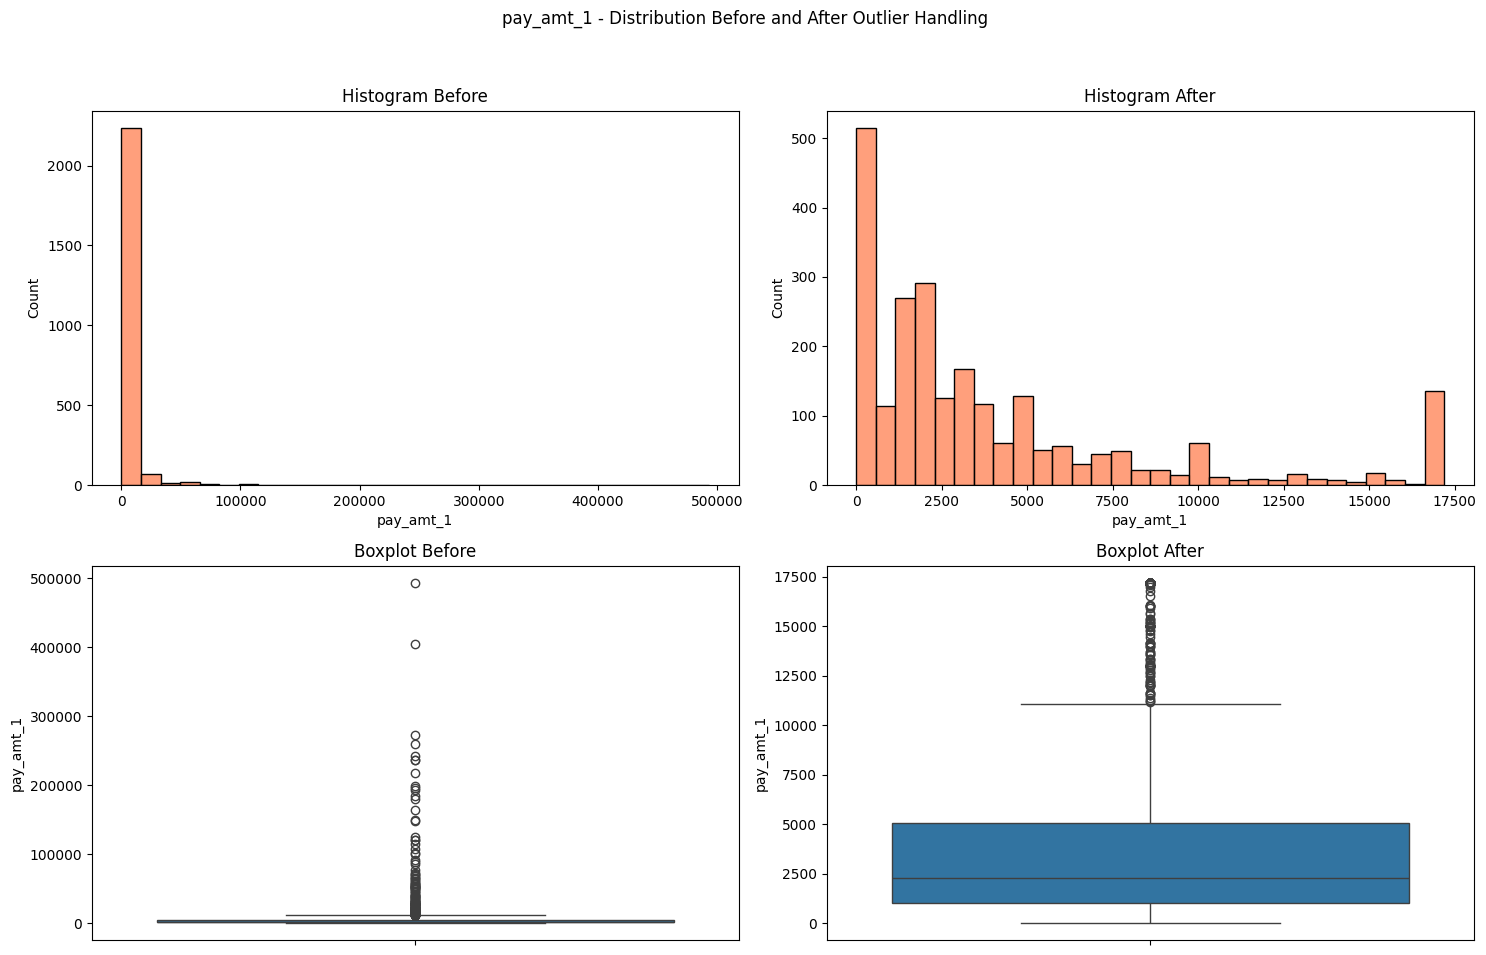

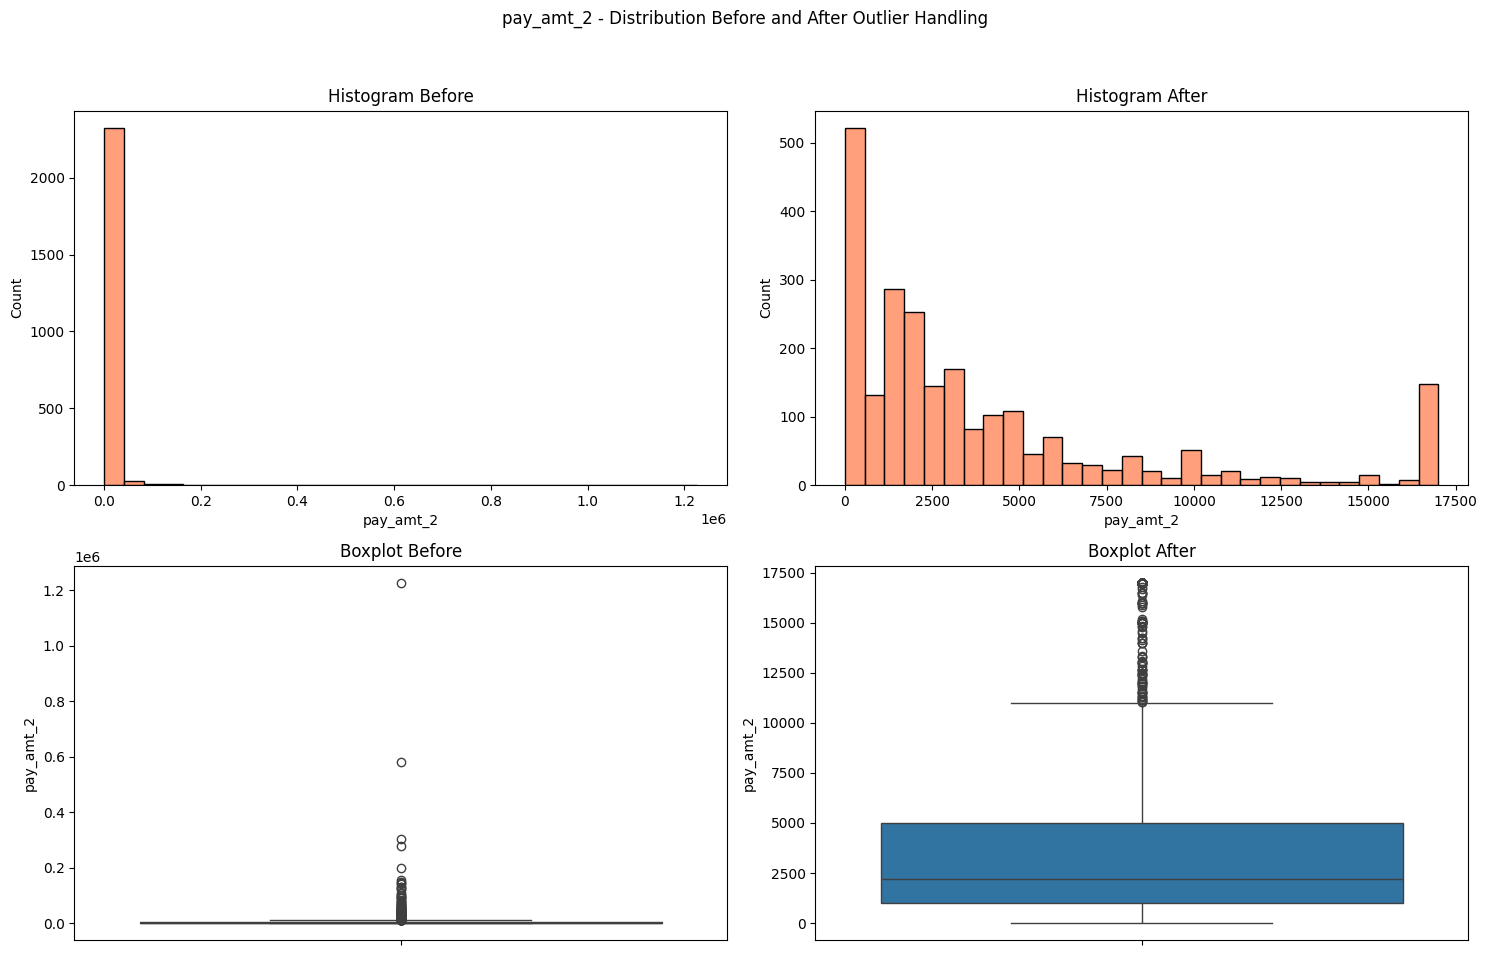

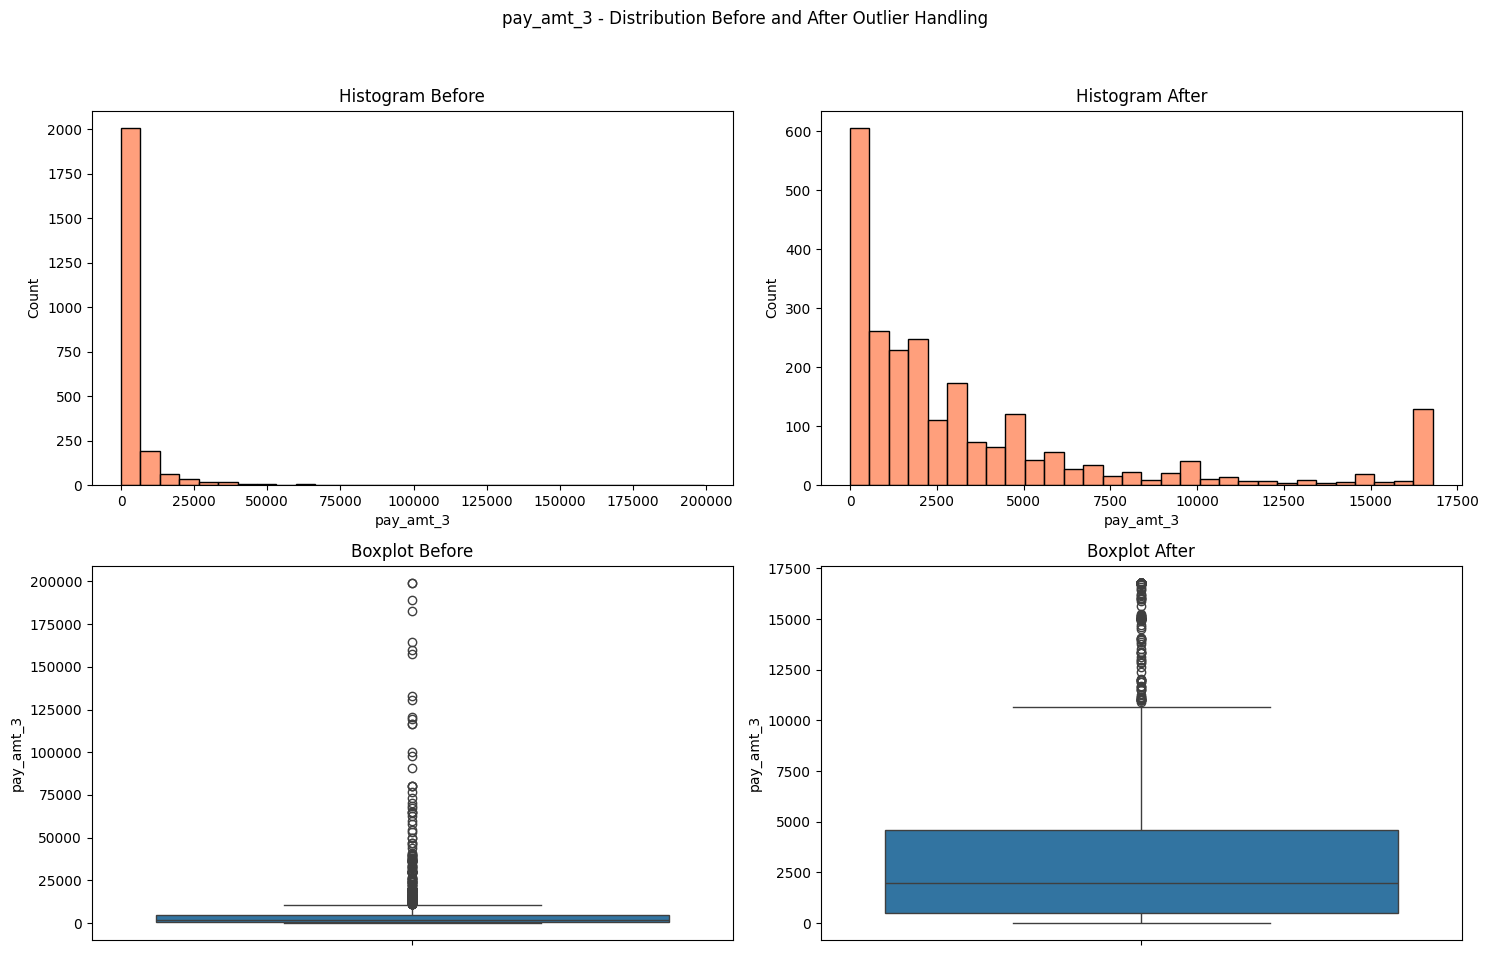

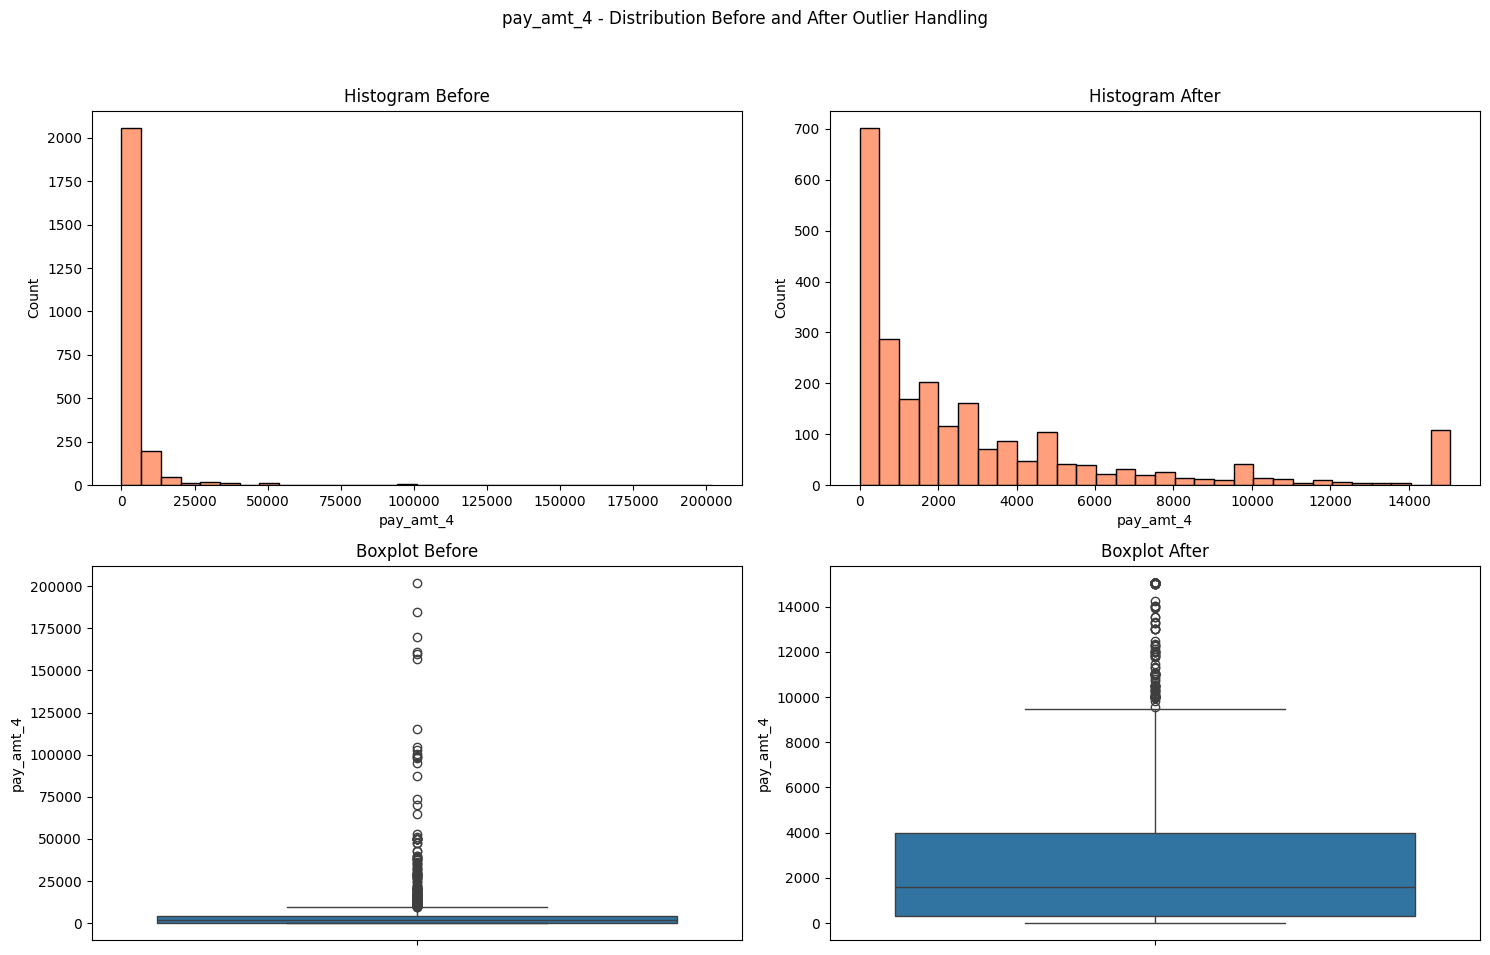

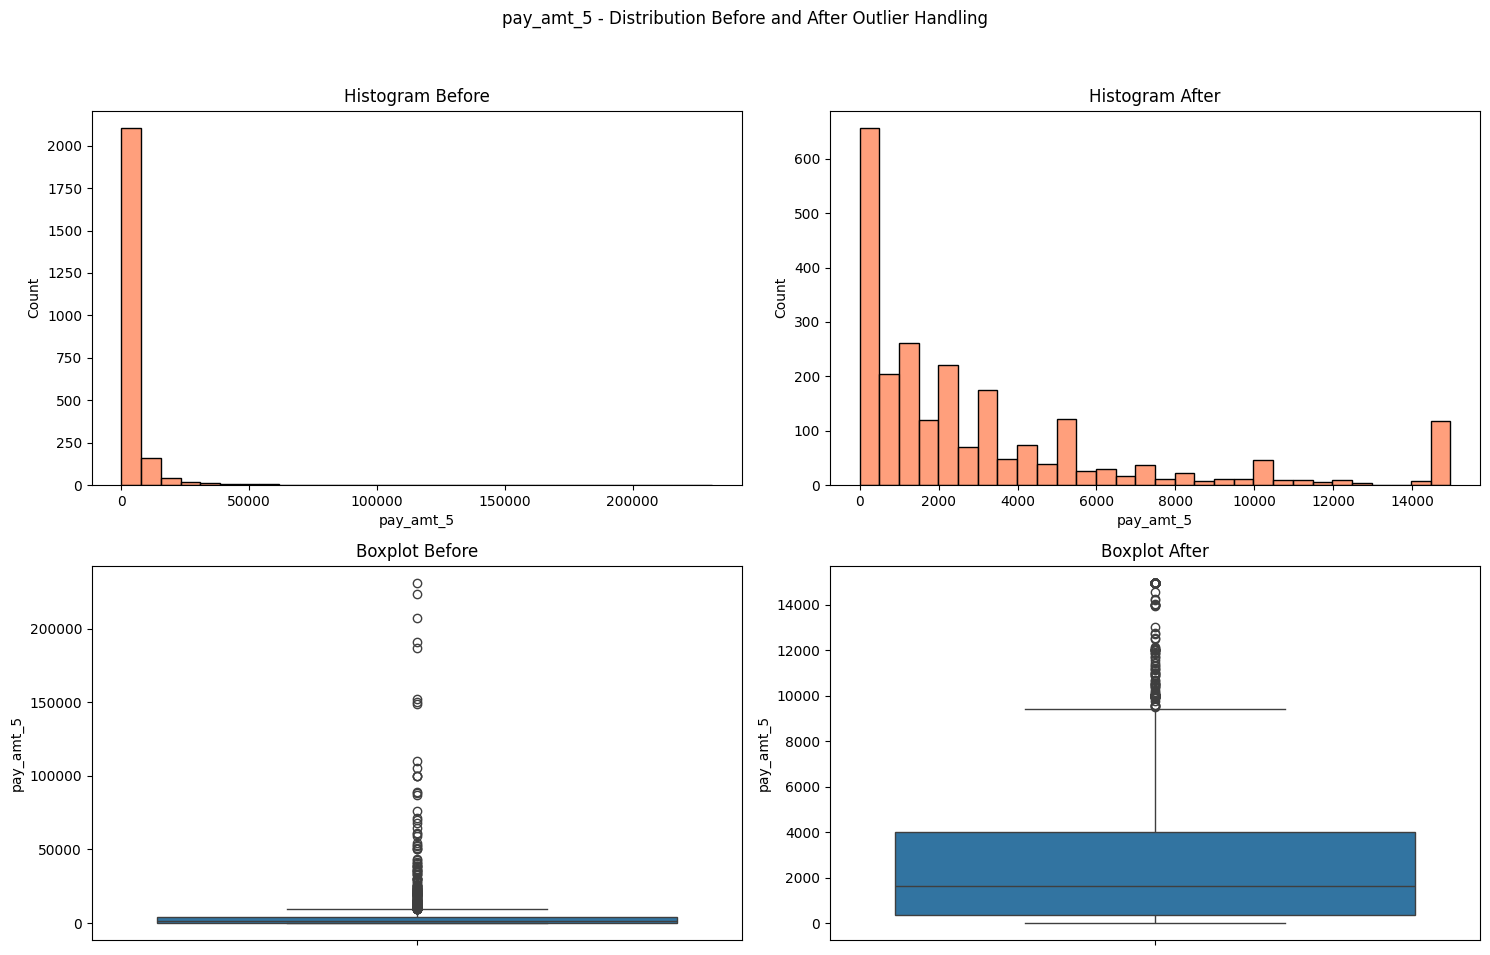

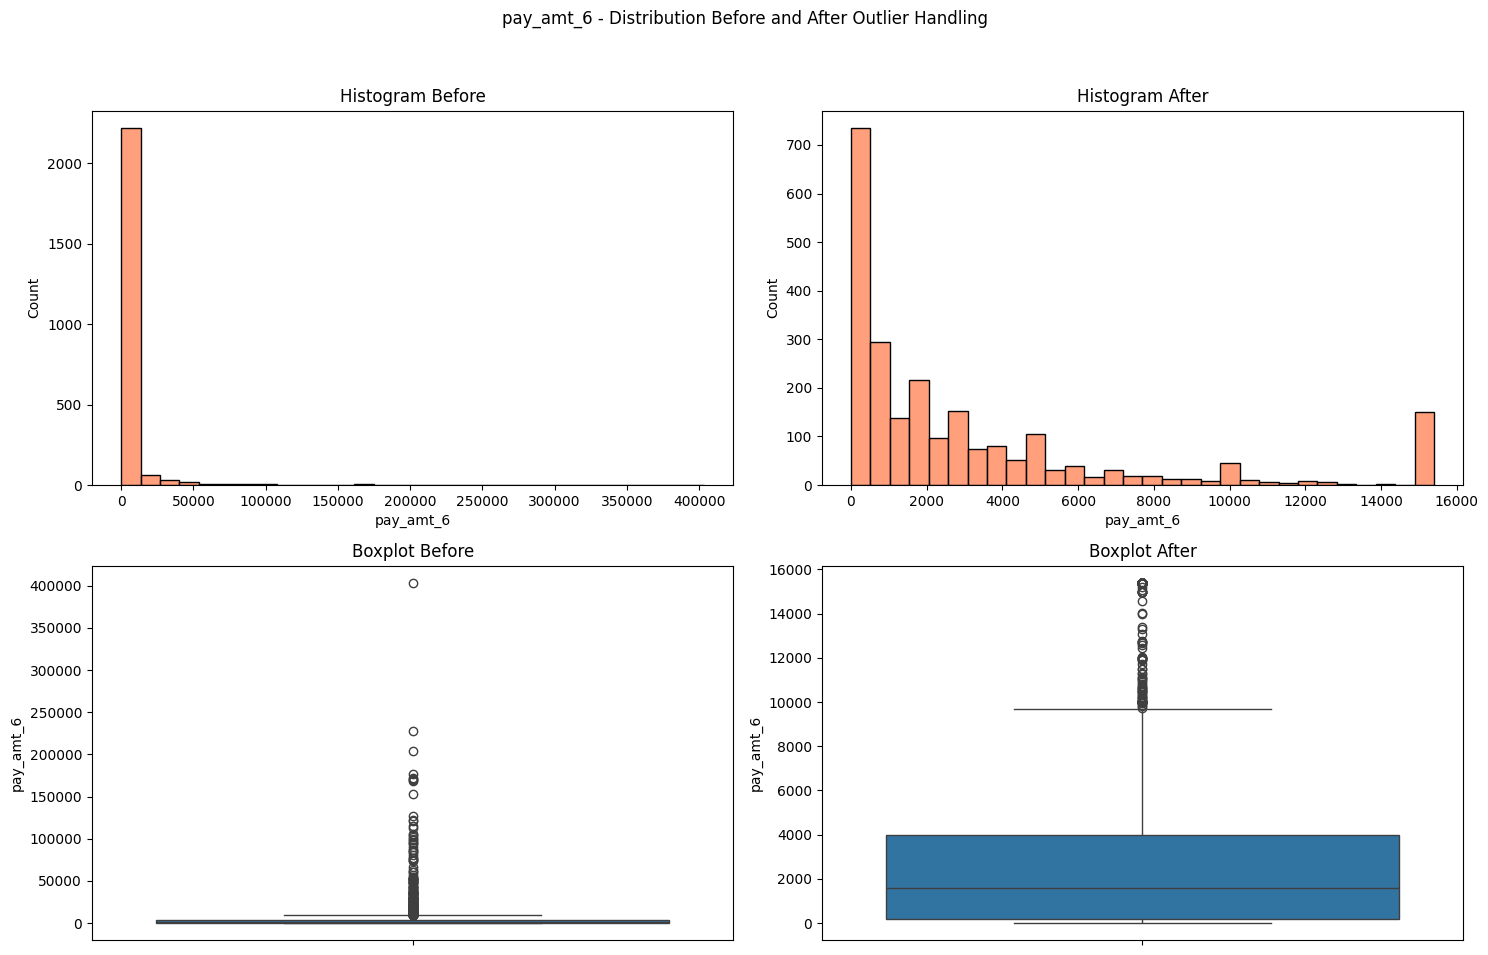

In [89]:
# Menampilkan visualisasi
for num in num_columns:
    outlier_handling_plot_comparison(X_train, X_train_capped, num)

Dikarenakan semua fitur yang numerical memiliki nilai skew yang rendah maka akan dilakukan penanganan outliernya mengunakan metode capping iqr dengan fold 3.

## Scaling and Encoding

Pada tahapan ini akan menggunakan pipeline untuk mentransformasi data agar siap digunakan dalam pemodelan pada tahap selanjutnya.

In [90]:
# menetapkan variable
X_train = X_train_capped
X_test = X_test_capped

In [91]:
# Selecting numerical and categorical columns
cat_columns = ['education_level','pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
num_columns = ['limit_balance','pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 
               'pay_amt_5','pay_amt_6']

print('Categorical Columns: ', cat_columns)
print('Numerical Columns: ', num_columns)

Categorical Columns:  ['education_level', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
Numerical Columns:  ['limit_balance', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']


In [92]:
# # Splitting the train and test features into categorical and numerical columns
# X_train_num = X_train_capped[num_columns]
# X_train_cat = X_train_capped[cat_columns]

# X_test_num = X_test_capped[num_columns]
# X_test_cat = X_test_capped[cat_columns]

### Column Transformer

Scaling pada column transformer dipilih menggunakan RoubustScaler dimana penggunaan scaling ini cocok untuk data yang memiliki outlier. Pada proses ini juga tidak dilakukan encoding pada kolom katergorical dikarenakan value pada kolom kategorical sudah dalam bentuk angka yang dapat langsung digunakan dalam proses machine learning.

In [93]:
# Numeric Features Scaling
num_pipe = Pipeline([('scaling', RobustScaler())])

# Preprocessing Pipeline
preprocess = ColumnTransformer([
    ('num', num_pipe, num_columns),
    ('cat', 'passthrough', cat_columns)
])

# VII Model Definition

Pada tahapan ini akan dibuat pipeline model dimana model yang digunakan adalah Logistic Regression, KNN, dan Suport Vector Clasifier.

## Model Definition

In [94]:
#Making pipeline for LogReg
pipe_logreg = Pipeline([
('transformer', preprocess),
('classifier', LogisticRegression())
])

In [95]:
#Making pipeline for KNN
pipe_KNN = Pipeline([
('transformer', preprocess),
('classifier', KNeighborsClassifier())
])

In [96]:
#Making pipeline for SVC
pipe_SVC = Pipeline([
('transformer', preprocess),
('classifier', SVC())
])

# VIII Model Training

Metrik evaluasi yang dipilih adalah f1-score dimana metrik ini memberikan gambaran yang seimbang antara precision dan recall. Data pada fitur target tidak seimbang maka f1-score yang digunakan adalah f1_weighted. 

Weighted F1-score akan memberikan gambaran yang lebih akurat tentang kinerja model pada dataset yang tidak seimbang dengan memperhitungkan frekuensi masing-masing kelas. Ini berarti bahwa kinerja pada kelas mayoritas (tidak default) dan kelas minoritas (default) akan diakui sesuai dengan proporsi mereka dalam dataset.

Pada Tahapan ini penggunaan cross validation akan digunakan untuk mencegah data leakage serta mendapatkan gambaran lebih baik terhadap kinerja model.

## Logistic Regresion

In [97]:
pipe_logreg.fit(X_train, y_train)
# Menghitung F1-score weighted pada data training
train_f1_score = f1_score(y_train, pipe_logreg.predict(X_train), average='weighted')

# Menghitung F1-score weighted pada data test
test_f1_score = f1_score(y_test, pipe_logreg.predict(X_test), average='weighted')

# Menampilkan hasil
print('Training F1-score (weighted):', round(train_f1_score, 4))
print('Testing F1-score (weighted):', round(test_f1_score, 4))

Training F1-score (weighted): 0.8057
Testing F1-score (weighted): 0.7854


In [98]:
# logreg predict
y_logreg_pred = pipe_logreg.predict(X_test)

In [99]:
# menampilkan classification report
target = ['Not Default', 'Default']
print(classification_report(y_test, y_logreg_pred, target_names = target))

              precision    recall  f1-score   support

 Not Default       0.83      0.95      0.89       466
     Default       0.62      0.31      0.41       127

    accuracy                           0.81       593
   macro avg       0.73      0.63      0.65       593
weighted avg       0.79      0.81      0.79       593



In [100]:
#Cross Validation

f1_train_cross_val = cross_val_score(pipe_logreg,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="f1_weighted")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.79589122 0.79516668 0.78930984 0.80876512 0.80165067]
F1 Score - Mean - Cross Validation :  0.7981567044651741
F1 Score - Std - Cross Validation  :  0.006589173775149545
F1 Score - Range of Test-Set       :  0.7915675306900245 - 0.8047458782403236


- Hasil F1-Score pada data pelatihan dan pengujian cukup konsisten, menunjukkan bahwa model tidak mengalami overfitting atau underfitting yang signifikan.
- F1-Score rata-rata dari cross-validation menunjukkan bahwa model memiliki performa yang stabil pada berbagai subset data, dengan variasi yang sangat kecil (std dev = 0.0066).
- Weighted average memberikan gambaran keseluruhan performa model yang lebih seimbang, memperhitungkan proporsi setiap kelas. Meskipun weighted F1-score lebih tinggi, perhatian khusus harus diberikan pada performa recall untuk kelas 'Default'

## KNN

In [101]:
pipe_KNN.fit(X_train, y_train)
# Menghitung F1-score weighted pada data train
train_f1_score = f1_score(y_train, pipe_KNN.predict(X_train), average='weighted')

# Menghitung F1-score weighted pada data test
test_f1_score = f1_score(y_test, pipe_KNN.predict(X_test), average='weighted')

# Menampilkan hasil
print('Training F1-score (weighted):', round(train_f1_score, 4))
print('Testing F1-score (weighted):', round(test_f1_score, 4))

Training F1-score (weighted): 0.8484
Testing F1-score (weighted): 0.7838


In [102]:
# knn predict
y_KNN_pred = pipe_KNN.predict(X_test)

In [103]:
# menampilkan clasification report
target = ['Not Default', 'Default']
print(classification_report(y_test, y_KNN_pred, target_names = target))

              precision    recall  f1-score   support

 Not Default       0.84      0.91      0.88       466
     Default       0.54      0.38      0.44       127

    accuracy                           0.80       593
   macro avg       0.69      0.64      0.66       593
weighted avg       0.78      0.80      0.78       593



In [104]:
#Cross Validation

f1_train_cross_val = cross_val_score(pipe_KNN,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="f1_weighted")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.80331293 0.79328542 0.78463824 0.8059883  0.80201566]
F1 Score - Mean - Cross Validation :  0.7978481114434282
F1 Score - Std - Cross Validation  :  0.007858932273647128
F1 Score - Range of Test-Set       :  0.7899891791697811 - 0.8057070437170752


- Hasil F1-Score pada data pelatihan lebih tinggi dibandingkan dengan data pengujian, menunjukkan ada kemungkinan overfitting pada model.
- F1-Score rata-rata dari cross-validation menunjukkan bahwa model memiliki performa yang stabil pada berbagai subset data, dengan variasi yang kecil (std dev = 0.0079).

## SVC

In [105]:
pipe_SVC.fit(X_train, y_train)
# Menghitung F1-score weighted pada data train
train_f1_score = f1_score(y_train, pipe_SVC.predict(X_train), average='weighted')

# Menghitung F1-score weighted pada data test
test_f1_score = f1_score(y_test, pipe_SVC.predict(X_test), average='weighted')

# Menampilkan hasil
print('Training F1-score (weighted):', round(train_f1_score, 4))
print('Testing F1-score (weighted):', round(test_f1_score, 4))

Training F1-score (weighted): 0.8331
Testing F1-score (weighted): 0.7963


In [106]:
# svc predict
y_SVC_pred = pipe_SVC.predict(X_test)

In [107]:
# menampilkan clasification report
target = ['Not Default', 'Default']
print(classification_report(y_test, y_SVC_pred, target_names = target))

              precision    recall  f1-score   support

 Not Default       0.84      0.95      0.89       466
     Default       0.64      0.35      0.45       127

    accuracy                           0.82       593
   macro avg       0.74      0.65      0.67       593
weighted avg       0.80      0.82      0.80       593



In [108]:
#Cross Validation

f1_train_cross_val = cross_val_score(pipe_SVC,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="f1_weighted")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.82459453 0.80436746 0.81689446 0.81931456 0.8203119 ]
F1 Score - Mean - Cross Validation :  0.8170965833906108
F1 Score - Std - Cross Validation  :  0.0068344484450734945
F1 Score - Range of Test-Set       :  0.8102621349455372 - 0.8239310318356843


- Perbedaan antara F1-Score pada data pelatihan dan pengujian menunjukkan adanya sedikit penurunan performa saat model diuji pada data yang tidak terlihat, mengindikasikan kemungkinan overfitting ringan.
- F1-Score rata-rata dari cross-validation mengindikasikan performa model yang stabil dengan variasi kecil, menunjukkan model memiliki konsistensi yang baik.

# IX Model Evaluation

Berdasarkan hasil pada proses sebelumnya model yang akan dituning adalah Logistic Regression dikarenakan memiliki indikasi overfit paling rendah dibandingkan kedua model lainnya. pada setiap model terdapat kelemahan yang sama dimana model kurang baik dalam memprediksi customers yang default.

## Hyperparameter Tuning

Pencarian Parameter terbaik menggunakan teknik GridCV dimana semua kombinasi hyperparameter akan diuji kemudian di pilih parameter terbaik untuk menjadi hyperparameter model yang terbaik.

In [109]:
# membuat hyperparameter
param_logreg = {
    'classifier__C': [0.01, 0.1, 1, 10],  # Regularization strength
    'classifier__solver': ['newton-cg','lbfgs', 'liblinear','saga'],  # Algorithm to use
    'classifier__penalty': ['l2'],  # Regularization term 
    'classifier__tol':[0.001,0.01],
    'classifier__class_weight': [None, 'balanced'], 
    'classifier__max_iter': [50, 100, 200]  # Maximum number of iterations
}

In [110]:
# membuat grid cv
grid_logreg = GridSearchCV(pipe_logreg, param_logreg, cv=3,scoring="f1_weighted")

In [111]:
# grid cv pipeline
grid_logreg.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaling',
                                                                                          RobustScaler())]),
                                                                         ['limit_balance',
                                                                          'pay_amt_1',
                                                                          'pay_amt_2',
                                                                          'pay_amt_3',
                                                                          'pay_amt_4',
                                                                          'pay_amt_5',
                                                                          'pay_amt_6']),
                                                                        ('cat',
                                                                         'passthrough',
                                                                         ['education_level',
                                                                          'pay_0',
                                                                          'pay_2',
                                                                          'pay_3',
                                                                          'pay_4',
                                                                          'pay_5',
                                                                          'pay_6'])])),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__class_weight': [None, 'balanced'],
                         'classifier__max_iter': [50, 100, 200],
                         'classifier__penalty': ['l2'],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear', 'saga'],
                         'classifier__tol': [0.001, 0.01]},
             scoring='f1_weighted')

In [112]:
# mengeluarkan best estimator
best_estimator_logreg = grid_logreg.best_estimator_
print(best_estimator_logreg)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['limit_balance', 'pay_amt_1',
                                                   'pay_amt_2', 'pay_amt_3',
                                                   'pay_amt_4', 'pay_amt_5',
                                                   'pay_amt_6']),
                                                 ('cat', 'passthrough',
                                                  ['education_level', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6'])])),
                ('classifier', LogisticRegression(C=1, max_iter=50, tol=0.01))])


In [113]:
# mengeluarkan best parameter
best_param_logreg = grid_logreg.best_params_
print(best_param_logreg)

{'classifier__C': 1, 'classifier__class_weight': None, 'classifier__max_iter': 50, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'classifier__tol': 0.01}


Setelah melakukan Grid CV ditemukan parameter yang paling bagus yaitu :

    'classifier__C': 1, 
    'classifier__class_weight': None, 
    'classifier__max_iter': 50, 
    'classifier__penalty': 'l2', 
    'classifier__solver': 'lbfgs', 
    'classifier__tol': 0.01

## Model After Tuning Comparison

In [114]:
# Koefisien dan intersep
print('Coefficient : ', pipe_logreg.named_steps['classifier'].coef_)
print('Intercept   : ', pipe_logreg.named_steps['classifier'].intercept_)

Coefficient :  [[-0.11343992 -0.05759211 -0.19215126 -0.05169914 -0.13365546  0.03289342
  -0.18128977 -0.03224409  0.66190704  0.04550645  0.12877379  0.00909887
   0.07997382  0.10257668]]
Intercept   :  [-1.21493463]


In [115]:
pipe_logreg.fit(X_train, y_train)
# Menghitung F1-score weighted pada data training
train_f1_score = f1_score(y_train, pipe_logreg.predict(X_train), average='weighted')

# Menghitung F1-score weighted pada data test
test_f1_score = f1_score(y_test, pipe_logreg.predict(X_test), average='weighted')

# Menampilkan hasil
print('Training F1-score (weighted):', round(train_f1_score, 4))
print('Testing F1-score (weighted):', round(test_f1_score, 4))

Training F1-score (weighted): 0.8057
Testing F1-score (weighted): 0.7854


In [116]:
# menampilkan koefisien dan intersep best estimator
print('Coefficient Best Estimator: ', best_estimator_logreg.named_steps['classifier'].coef_)
print('Intercept Best Estimator: ', best_estimator_logreg.named_steps['classifier'].intercept_)

Coefficient Best Estimator:  [[-0.1086858  -0.07755691 -0.21519506 -0.07110219 -0.12938904  0.01235526
  -0.18520378 -0.36436715  0.65219903  0.11069482  0.10105571  0.02625258
   0.09025215  0.10593596]]
Intercept Best Estimator:  [-0.51769865]


In [117]:
# menampikan f1-score weigted
print('Training Score F1-score (weighted) Best Estimator: ',round(best_estimator_logreg.score(X_train, y_train),4))
print('Testing ScoreF1-score (weighted) Best Estimator: ', round(best_estimator_logreg.score(X_test, y_test),4))

Training Score F1-score (weighted) Best Estimator:  0.8312
Testing ScoreF1-score (weighted) Best Estimator:  0.8061


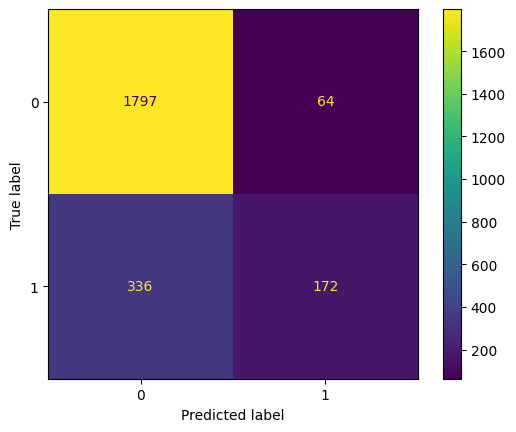

In [118]:
# menampilkan confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train, best_estimator_logreg.predict(X_train))
plt.show()

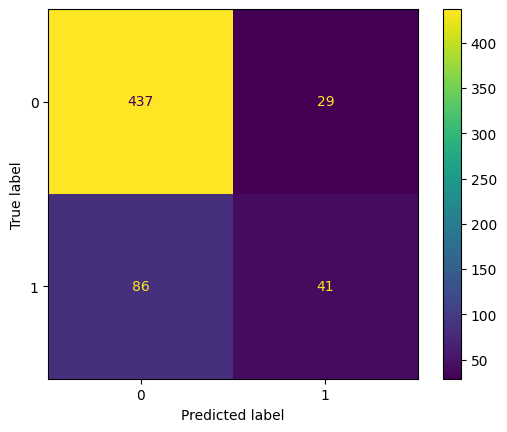

In [119]:
# menampilkan confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, best_estimator_logreg.predict(X_test))
plt.show()

## Model Analysis 

Perbandingan Koefisien:

- Perubahan koefisien setelah tuning menunjukkan adanya penyesuaian signifikan dalam beberapa fitur. Terutama pada fitur kedelapan (-0.03224409 menjadi -0.36436715) dan kesembilan (0.66190704 menjadi 0.65219903), menunjukkan bahwa fitur ini memiliki pengaruh yang lebih besar pada model setelah tuning.


Perbandingan Intersep:

- Perubahan intersep dari -1.21493463 menjadi -0.51769865 menunjukkan bahwa dasar probabilitas untuk prediksi kelas telah berubah, menyesuaikan dengan distribusi data yang lebih baik setelah tuning.


Perbandingan Performa:

- Training F1-score meningkat dari 0.8057 menjadi 0.8312, menunjukkan bahwa model setelah tuning lebih mampu menyesuaikan diri dengan data pelatihan.
Testing F1-score meningkat dari 0.7854 menjadi 0.8061, menunjukkan bahwa model setelah tuning juga memiliki generalisasi yang lebih baik terhadap data yang tidak terlihat.


Interpretasi Koefisien:
- Koefisien positif menunjukkan bahwa peningkatan dalam fitur tersebut meningkatkan log odds dari default payment (atau kejadian target).
- Koefisien negatif menunjukkan bahwa peningkatan dalam fitur tersebut menurunkan log odds dari default payment.

Misalnya:
- Fitur kedelapan: Peningkatan koefisien negatif secara signifikan setelah tuning menunjukkan bahwa fitur ini semakin penting dalam menurunkan kemungkinan default payment.
- Fitur kesembilan: Tetap mempertahankan koefisien yang sangat tinggi positif menunjukkan bahwa fitur ini secara konsisten sangat penting dalam meningkatkan kemungkinan default payment.

- Model Setelah Tuning menunjukkan performa yang lebih baik baik pada data pelatihan maupun pengujian, yang ditunjukkan oleh peningkatan F1-score.
- Perubahan Koefisien mengindikasikan penyesuaian model terhadap fitur-fitur penting yang mempengaruhi probabilitas default payment secara lebih akurat.
- Interpretasi dari koefisien model yang dituning dapat memberikan wawasan lebih dalam tentang bagaimana setiap fitur mempengaruhi prediksi, memungkinkan untuk strategi mitigasi risiko yang lebih baik.

# X Model Saving

In [120]:
# meninyimpan model
import pickle

pickle.dump(best_estimator_logreg, open('model_logreg.pkl', 'wb'))

# XI Model Inference

In [121]:
# Menampilkan data inference

data_inf

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,360000.0,2,2,2,53.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,10733.0,15206.0,15000.0,9744.0,11114.0,8123.0,15206.0,15032.0,9769.0,11114.0,8123.0,8736.0,0
1,260000.0,1,1,2,30.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,2322.0,1233.0,3302.0,6592.0,5008.0,3386.0,1233.0,3302.0,6592.0,5008.0,3386.0,2547.0,0


## Inference Prediction

In [122]:
# Ridge Regression Prediction
y_pred_inf_logreg = best_estimator_logreg.predict(data_inf)
y_pred_inf_logreg

array([0, 0], dtype=int64)

In [123]:
y_pred_inf_logreg_df = pd.DataFrame(y_pred_inf_logreg, columns=['Prediction'])
pred_inf = pd.concat([data_inf['default_payment_next_month'],y_pred_inf_logreg_df], axis=1)
pred_inf

,default_payment_next_month,Prediction
0,0,0
1,0,0


Berdasarkan hasil pengujian model berhasil memprediksi dengan benar akan tetapi perlu di garis bawahi bahwa pengujian pada data inference target yang di prediksi adalah yang tidak default dimana model memiliki nilai akurasi yang tinggi yang membuat kecenderungan untuk lebih efective dalam memprediksi customers yang tidak default dibandingkan default

# XII Kesimpulan

- Berdasarkan analisis data, terlihat bahwa pelanggan yang membayar tepat waktu lebih banyak dibandingkan yang tidak, menunjukkan adanya imbalance data. Semua pelanggan memiliki potensi gagal bayar, namun risiko lebih tinggi pada mereka yang pernah terlambat lebih dari dua bulan. Secara demografis, pelanggan yang belum menikah dan menikah memiliki tingkat gagal bayar tertinggi masing-masing 22,7% dan 20,5%. Dari segi pendidikan, pelanggan dengan pendidikan sekolah menengah dan sarjana memiliki tingkat gagal bayar tertinggi, masing-masing 16,9% dan 24,4%. Analisis gender menunjukkan laki-laki memiliki risiko gagal bayar sedikit lebih tinggi (22,5%) dibandingkan perempuan (20,7%). Insight ini penting untuk pengelolaan risiko kredit, menekankan perlunya perhatian khusus pada kelompok-kelompok dengan risiko gagal bayar yang lebih tinggi.

- Berdasarkan evaluasi model, regresi logistik menunjukkan hasil F1-Score yang konsisten antara data pelatihan dan pengujian, serta performa stabil dengan variasi sangat kecil dari cross-validation, mengindikasikan tidak adanya overfitting atau underfitting yang signifikan dan menunjukkan performa yang seimbang dengan weighted F1-score. Model KNN menunjukkan indikasi overfitting karena F1-Score pada data pelatihan lebih tinggi dibandingkan data pengujian, meskipun cross-validation menunjukkan performa stabil dengan variasi kecil. SVC juga menunjukkan sedikit overfitting dengan penurunan performa pada data pengujian dibandingkan data pelatihan, tetapi tetap memiliki konsistensi yang baik berdasarkan cross-validation. Secara keseluruhan, regresi logistik tampak sebagai model yang paling seimbang dan stabil di antara ketiganya.

- Setelah tuning, model regresi logistik menunjukkan peningkatan signifikan dalam performa dengan F1-score yang lebih tinggi pada data pelatihan (dari 0.8057 menjadi 0.8312) dan data pengujian (dari 0.7854 menjadi 0.8061). Perubahan koefisien, terutama pada fitur kedelapan dan kesembilan, serta penyesuaian intersep menunjukkan bahwa model telah disesuaikan lebih baik terhadap distribusi data, sehingga memberikan prediksi yang lebih akurat dan memungkinkan analisis yang lebih mendalam tentang pengaruh setiap fitur terhadap kemungkinan default payment.

- Kelebihan dari model setelah tuning termasuk peningkatan performa baik pada data pelatihan maupun pengujian, yang menunjukkan kemampuan generalisasi yang lebih baik. Perubahan koefisien memberikan wawasan lebih mendalam tentang pentingnya fitur-fitur tertentu, membantu dalam strategi mitigasi risiko yang lebih efektif. Namun, kekurangannya adalah potensi overfitting jika tuning tidak dilakukan dengan hati-hati, serta interpretasi yang lebih kompleks dari koefisien yang berubah, yang mungkin memerlukan analisis tambahan untuk memahami pengaruh spesifik dari setiap fitur.

- Dikarenakan fitur taget termasuk imbalance perlu dilakukan data balancing untuk menaikan performa model, serta penambahan PCA untuk dimensional reduction.

# Conceptual Problems

1. **Coeficient pada Logistic Regression**: Koefisien dalam logistic regression mengacu pada nilai yang diberikan untuk setiap fitur dalam model. Ini menunjukkan kontribusi relatif dari masing-masing fitur terhadap prediksi kelas target.

2. **Fungsi Parameter Kernel pada SVM**: Kernel pada Support Vector Machine (SVM) adalah fungsi matematis yang digunakan untuk mengubah data input ke dalam bentuk yang lebih dimengerti oleh SVM. Salah satu kernel yang umum digunakan adalah kernel RBF (Radial Basis Function), yang menggunakan fungsi Gaussian untuk mengukur jarak antara titik-titik dalam ruang fitur.

3. **Cara Memilih K yang Optimal pada KNN**: Memilih nilai K yang optimal pada K-Nearest Neighbors (KNN) biasanya melibatkan teknik cross-validation. Nilai K yang memberikan kinerja terbaik pada set validasi akan dipilih sebagai nilai K yang optimal.

4. **Metrics pada Klasifikasi**: 
   - **Accuracy**: Akurasi mengukur seberapa sering model klasifikasi membuat prediksi yang benar.
   - **Precision**: Presisi mengukur proporsi positif yang diprediksi dengan benar dari total positif yang diprediksi.
   - **Recall**: Recall (sensitivitas) mengukur proporsi positif yang diprediksi dengan benar dari total positif sebenarnya.
   - **F1 Score**: F1 score adalah rata-rata harmonik dari precision dan recall, memberikan keseimbangan antara kedua metrik tersebut.
   
   Pilihan metrik tergantung pada tujuan bisnis dan preferensi pemodelan, seperti prioritas dalam mengurangi false positive atau false negative.

hugging face = https://huggingface.co/spaces/Gieorgie/Credit_Card_Default_Prediction